In [1]:
# cd CrisisMMD_Dataset

In [2]:
#ensuring that any edits to libraries you make are reloaded here automatically
#to ensuere charts or images displayed are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [3]:
#importing required modules
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import *
from exp.Required_Functionalities_To_Handal_Multimodal_Dataset import *
from exp.Multimodal_Model_With_Intermediate_Or_EmbraceNet_Fusion import *

In [5]:
path = Path('/notebooks/CrisisMMD_Dataset')
# path.ls()

In [6]:
path_img = path/'data_image'

In [7]:
# Uncomment the code if dataset and labels are in .tar.gz and .zip format respectively

# data = "CrisisMMD_v2.tar.gz"
# agreed_label = "crisismmd_datasplit_agreed_label.zip"
# untar_data_and_unzip_label(data,agreed_label)

In [9]:
#reading csv files and doing initial necessary processing
data_info_text,test_data_info_text = get_dataframe(*get_tsv_data_files('Informativeness_task_tsv_files'),path)

In [11]:
print(f"shape of data: {data_info_text.shape}\n")
print(f"train set: {data_info_text['is_valid'].value_counts()[0]}")
print(f"valid set: {data_info_text['is_valid'].value_counts()[1]}")      
print("="*50)
print(f"shape of test data: {test_data_info_text.shape}\n")

shape of data: (11174, 11)

False    9601
True     1573
Name: is_valid, dtype: int64
shape of test data: (11135, 11)

False    9601
True     1534
Name: is_test, dtype: int64


In [12]:
data_info_text.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image,is_valid,is_test
0,california_wildfires,917791291823591425,917791291823591425_0,pls share were capturing wildfire response rec...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False,False
1,california_wildfires,917793137925459968,917793137925459968_0,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False,False
2,california_wildfires,917793137925459968,917793137925459968_1,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False,False
3,california_wildfires,917793137925459968,917793137925459968_2,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False,False
4,california_wildfires,917815040962695168,917815040962695168_0,photos of california destructive wildfires via,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False,False


In [13]:
test_data_info_text.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image,is_valid,is_test
0,california_wildfires,917791291823591425,917791291823591425_0,pls share were capturing wildfire response rec...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False,False
1,california_wildfires,917793137925459968,917793137925459968_0,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False,False
2,california_wildfires,917793137925459968,917793137925459968_1,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False,False
3,california_wildfires,917793137925459968,917793137925459968_2,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False,False
4,california_wildfires,917815040962695168,917815040962695168_0,photos of california destructive wildfires via,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False,False


In [14]:
data_info_text['tweet_text'][0]

'pls share were capturing wildfire response recovery info here'

In [15]:
# preparing data for language model to get encoder and word embedding vocab for text classification model
data_lm = get_text_data_for_language_model(data_info_text,path)

In [16]:
data_lm

TextLMDataBunch;

Train: LabelList (9601 items)
x: LMTextList
xxbos pls share were xxunk wildfire response recovery info here,xxbos california wildfires destroy more than structures kakenews,xxbos california wildfires destroy more than structures kakenews,xxbos california wildfires destroy more than structures kakenews,xxbos photos of california destructive wildfires via
y: LMLabelList
,,,,
Path: /notebooks/CrisisMMD_Dataset;

Valid: LabelList (1573 items)
x: LMTextList
xxbos we ve lost track of how many xxunk teams have helped so proud of our church harvey,xxbos the xxunk above xxunk got destroyed the xxunk wall got blown out hurricanemaria,xxbos californias xxunk fire in xxunk captured in pictures and videos xxunk,xxbos one of the first solar storage tesla energy projects in puerto rico has come online,xxbos tornado warning including xxunk wa xxunk river wa deep river wa until pm xxunk
y: LMLabelList
,,,,
Path: /notebooks/CrisisMMD_Dataset;

Test: None

In [17]:
# showing the data with corresponding annotations
data_lm.show_batch()

idx,text
0,in the fall xxbos why california wildfires are worse in the fall xxbos playing with my new friend chai she california fire evacuee starting with us for few days her xxbos playing with my new friend chai she california fire evacuee starting with us for few days her xxbos playing with my new friend chai she california fire evacuee starting with us for few days her xxbos playing with my
1,xxbos weather forecast stjune slfloods floodsl lka dmclk english and sinhala xxbos weather forecast stjune slfloods floodsl lka dmclk english and sinhala xxbos what does dignity kit xxunk check it out floodsl xxunk xxbos what does dignity kit xxunk check it out floodsl xxunk xxbos visiting flood victimes in bullathsinhala floodsl srilanka namalrajapaksa xxbos visiting flood victimes in bullathsinhala floodsl srilanka namalrajapaksa xxbos visiting flood victimes in bullathsinhala floodsl srilanka
2,stainless knife xxbos jewelry fashion buy now mora wood carving knives stainless knife xxbos jewelry fashion buy now mora wood carving knives stainless knife xxbos big saturday is coming up we are ready for the nd phase of contribution floodsl a xxbos big saturday is coming up we are ready for the nd phase of contribution floodsl a xxbos big saturday is coming up we are ready for the nd
3,great talent tomorrow at in support of sismomx please come xxbos xxunk families in mexico bought xxunk to help peoples after earthquake xxrep 4 d xxunk xxbos this is shocking and very fearful thirteen year mexico earthquake prophecy by prophetdrowuor fulfilled xxbos this is shocking and very fearful thirteen year mexico earthquake prophecy by prophetdrowuor fulfilled xxbos this is shocking and very fearful thirteen year mexico earthquake prophecy by prophetdrowuor
4,red crescent cooperates with iraqi red crescent in order to alleviate needs of earthquake victims in iraq xxbos turkish red crescent cooperates with iraqi red crescent in order to alleviate needs of earthquake victims in iraq xxbos no action from iran government and other countries to help recent earthquake in iran because they are kurds xxbos no action from iran government and other countries to help recent earthquake in iran


In [18]:
# importing pretrained AWD_LSTM model and making learner object consist of data,model for training
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [19]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


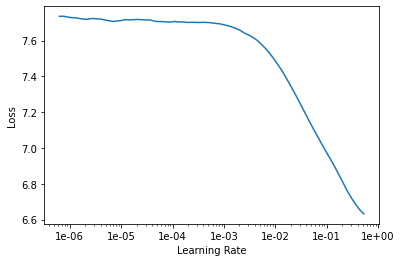

In [20]:
learn_lm.recorder.plot(skip_end=15)

In [21]:
# training the top layer's while keeping bottom layer's in freeze state
learn_lm.fit_one_cycle(2,5e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.780850,4.874761,0.224509,00:03
1,4.833481,4.774655,0.230670,00:03


In [22]:
learn_lm.unfreeze()

In [23]:
learn_lm.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.160178,4.920825,0.230179,00:03


In [24]:
# saving encoder for using it in classification model
learn_lm.save_encoder('fine_tuned_enc_info')

In [25]:
# preprocessing and creating databunch object for data(train and dev split) and test data(test split)
data_clas = get_text_data(data_info_text,path,vocab=data_lm.vocab)
test_data_clas = get_test_text_data(test_data_info_text,path,vocab=data_lm.vocab)

In [26]:
# making single databunch object of data and test data
data_clas.add_test(test_data_clas.train_ds)
data_clas.test_ds.y = test_data_clas.train_ds.y

In [27]:
data_clas

TextClasDataBunch;

Train: LabelList (9601 items)
x: TextList
xxbos pls share were xxunk wildfire response recovery info here,xxbos california wildfires destroy more than structures kakenews,xxbos california wildfires destroy more than structures kakenews,xxbos california wildfires destroy more than structures kakenews,xxbos photos of california destructive wildfires via
y: CategoryList
informative,informative,informative,informative,informative
Path: /notebooks/CrisisMMD_Dataset;

Valid: LabelList (1573 items)
x: TextList
xxbos we ve lost track of how many xxunk teams have helped so proud of our church harvey,xxbos the xxunk above xxunk got destroyed the xxunk wall got blown out hurricanemaria,xxbos californias xxunk fire in xxunk captured in pictures and videos xxunk,xxbos one of the first solar storage tesla energy projects in puerto rico has come online,xxbos tornado warning including xxunk wa xxunk river wa deep river wa until pm xxunk
y: CategoryList
informative,informative,infor

In [28]:
# showing data with labels
data_clas.show_batch()

text,target
xxbos ya ll be sure to get in on this week xxunk ve got to know what you think you know in case need to know,not_informative
xxbos if all were wondering how long it would take florida to get back to be being florida in the wake of irma here is,not_informative
xxbos all eyes on maria as it heads over simliar islands that got hit with irma sending fto them as we watch it closely,informative
xxbos all eyes on maria as it heads over simliar islands that got hit with irma sending fto them as we watch it closely,informative
xxbos ken former london mayor is in my xxunk ken at mora rd xxunk station to vote for to be pm jeremy this morning,not_informative


In [29]:
# importing pretrained AWD-LSTM model and making learner object consist of data,model,metrics and callbacks for training
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,metrics=[accuracy,Precision(average='macro'),
                Precision(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)],
            callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3),
               partial(ReduceLROnPlateauCallback,monitor='valid_loss', mode='auto', patience=0,
                       factor=0.2, min_delta=0, min_lr=0.000001)]  
            )

In [30]:
# laoding encoder for classification
learn_clas.load_encoder('fine_tuned_enc_info')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9601 items)
x: TextList
xxbos pls share were xxunk wildfire response recovery info here,xxbos california wildfires destroy more than structures kakenews,xxbos california wildfires destroy more than structures kakenews,xxbos california wildfires destroy more than structures kakenews,xxbos photos of california destructive wildfires via
y: CategoryList
informative,informative,informative,informative,informative
Path: /notebooks/CrisisMMD_Dataset;

Valid: LabelList (1573 items)
x: TextList
xxbos we ve lost track of how many xxunk teams have helped so proud of our church harvey,xxbos the xxunk above xxunk got destroyed the xxunk wall got blown out hurricanemaria,xxbos californias xxunk fire in xxunk captured in pictures and videos xxunk,xxbos one of the first solar storage tesla energy projects in puerto rico has come online,xxbos tornado warning including xxunk wa xxunk river wa deep river wa until pm xxunk
y: CategoryList
informative,i

In [31]:
# training model using discriminative fine-tunnig and gradual unfreezing
learn_clas.lr_find()

epoch,train_loss,valid_loss,accuracy,precision,precision,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


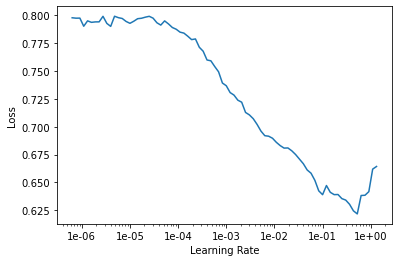

In [32]:
learn_clas.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision,precision,recall,recall,f_beta,f_beta,time
0,0.472507,0.433153,0.805467,0.789026,0.800953,0.754412,0.805467,0.766731,0.799303,00:05
1,0.432737,0.421209,0.816910,0.794677,0.814420,0.784161,0.816910,0.788898,0.815248,00:05


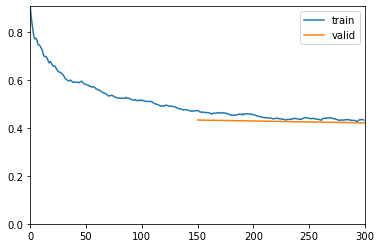

In [33]:
# training the model's top layer's keeping keep other layer's in freezing mode, all the metrics shown here, have been
# evaluted on validation set
learn_clas.fit_one_cycle(2,5e-3,moms=(0.8,0.7),wd=1e-1)

epoch,train_loss,valid_loss,accuracy,precision,precision,recall,recall,f_beta,f_beta,time
0,0.432432,0.430090,0.814367,0.799759,0.810472,0.765484,0.814367,0.777954,0.808765,00:05
1,0.398499,0.397150,0.824539,0.811258,0.821214,0.778983,0.824539,0.791143,0.819761,00:05
2,0.346507,0.396669,0.823268,0.812346,0.820226,0.774087,0.823268,0.787812,0.817533,00:05


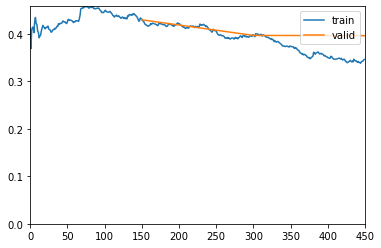

In [34]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7),wd=1e-1)

In [35]:
# learn_clas.freeze_to(-3)
# learn_clas.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,precision,precision,recall,recall,f_beta,f_beta,time
0,0.324294,0.398584,0.824539,0.815273,0.821853,0.774047,0.824539,0.788543,0.818438,00:06
1,0.322164,0.394235,0.820089,0.807268,0.816645,0.771720,0.820089,0.784665,0.814592,00:06
2,0.318857,0.413128,0.826446,0.815414,0.823482,0.778923,0.826446,0.792274,0.821144,00:05
3,0.285250,0.413656,0.830261,0.819077,0.827391,0.784726,0.830261,0.797585,0.825452,00:06


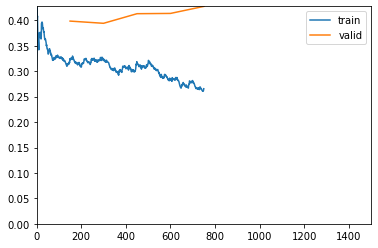

Better model found at epoch 0 with accuracy value: 0.8245391249656677.
Epoch 2: reducing lr to 0.0002
Better model found at epoch 2 with accuracy value: 0.8264462947845459.
Epoch 3: reducing lr to 0.00019009692640269474
Better model found at epoch 3 with accuracy value: 0.8302606344223022.
Epoch 4: early stopping
Epoch 4: reducing lr to 0.00016234913078995263


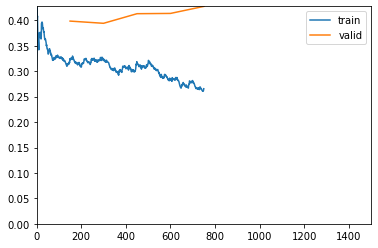

In [36]:
# training all layer's of the model and saving the best one
learn_clas.unfreeze()
learn_clas.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7),
                    callbacks=[SaveModelCallback(learn_clas,every='improvement', monitor='accuracy', name='best')])

In [63]:
# making interpretation on dev split
interp = ClassificationInterpretation.from_learner(learn_clas)

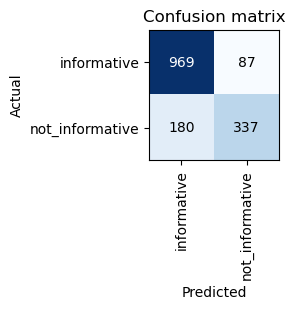

In [64]:
#plotting the confusion matrix
interp.plot_confusion_matrix(figsize=(3,3), dpi=100)

In [39]:
#making predictions on validation set to use it in classification report
preds,y,losses = learn_clas.get_preds(ds_type=DatasetType.Valid,with_loss=True)

y_preds = preds.argmax(1)

In [40]:
target_names = ['informative', 'non-informative']
print(classification_report(y, y_preds, target_names=target_names))

                 precision    recall  f1-score   support

    informative       0.84      0.92      0.88      1056
non-informative       0.79      0.65      0.72       517

       accuracy                           0.83      1573
      macro avg       0.82      0.78      0.80      1573
   weighted avg       0.83      0.83      0.83      1573



In [41]:
learn_clas.validate(data_clas.test_dl,metrics=[accuracy,Precision(average='macro'),Precision(average='weighted'),
                                                     Recall(average='macro'),Recall(average='weighted'),
                                                    FBeta(average='macro',beta=1),FBeta(average='weighted',beta=1)])

[0.37498662,
 tensor(0.8416),
 tensor(0.8302),
 tensor(0.8391),
 tensor(0.8015),
 tensor(0.8416),
 tensor(0.8129),
 tensor(0.8380)]

In [42]:
#making predictions on test set to use it in classification report
preds,y,losses = learn_clas.get_preds(ds_type=DatasetType.Test,with_loss=True)

In [43]:
y_preds = preds.argmax(1)

In [45]:
print(classification_report(y, y_preds, target_names=target_names))

                 precision    recall  f1-score   support

    informative       0.87      0.89      0.88      1030
non-informative       0.77      0.74      0.76       504

       accuracy                           0.84      1534
      macro avg       0.82      0.82      0.82      1534
   weighted avg       0.84      0.84      0.84      1534



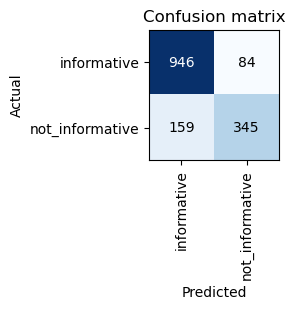

In [67]:
interp = ClassificationInterpretation.from_learner(learn_clas,ds_type=DatasetType.Test)
interp.plot_confusion_matrix(figsize=(3,3), dpi=100)

In [47]:
learn_clas.save("Informative_text_only")